# Shoot N Dodge

In this assignment, you will be programming an agent to be able to play a new Atari game called *ShootNDodge*.




## Game description


## Installing the game

The game is provided as a python package and can be run as an **OpenAI-Gym** environment. To do so, you will have to go to the setup folder and install the package on your python virtual environment.

In [1]:
!pip install -e gym-shootndodge/.

Obtaining file:///home/hamidreza/Courses/SUT-AI/F2021-P5/DQN/gym-shootndodge
  Attempting uninstall: gym-shootndodge
    Found existing installation: gym-shootndodge 0.0.88
    Uninstalling gym-shootndodge-0.0.88:
      Successfully uninstalled gym-shootndodge-0.0.88
  Running setup.py develop for gym-shootndodge


Now you can easily create the environment similar to any other gym environment using the code below:

In [3]:
ENV_NAME = 'shootndodge-v0'

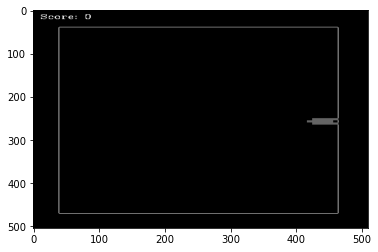

In [4]:
import numpy as np
import gym
import gym_shootndodge
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make(ENV_NAME)
obs = env.reset()
plt.imshow(env.render(mode='rgb_array'), aspect='auto')
plt.show()

Run the game in frames to see what it looks like:

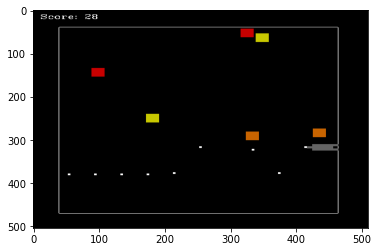

In [14]:
from IPython.display import clear_output
env = gym.make(ENV_NAME)
env.seed(2022)
obs = env.reset()
a = 2
for i in range(5000):
    if (i + 1) % 40 == 0:
        a = env.action_space.sample()
    observation, reward, done, info = env.step(a)
   
    if (i + 1) % 5 == 0:
        clear_output(True)
        screen = env.render(mode='rgb_array')
        plt.imshow(screen, aspect='auto')
        plt.show()
    if done:
        break

### Let's play a little

Pay attention to zoom and play function. Control: Up arrow, Down arrow.


In [ ]:
# # does not work in Colab.
# # make keyboard interrupt to continue

# from gym.utils.play import play

# play(env=gym.make(ENV_NAME), zoom=5, fps=30)

### Preprocessing game image

The raw Atari image is large, 504x510x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including

Resizing to a smaller shape, 64 x 64
Converting to grayscale
Cropping irrelevant image parts (top, bottom and edges)
Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This dirty trick is not necessary but it will speed up learning.

In [15]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

badblock_colors = [(200, 200, 0), (153, 76, 0), (204, 0, 0)]

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env, gray_scale=False):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (64, 64, 1 if gray_scale else env.observation_space.shape[2]))

        self.gray_scale = gray_scale
        
    def _to_gray_scale(self, rgb, channel_weights=[0.6, 0.3, 0.1]):
        gray_img = np.zeros((rgb.shape[0], rgb.shape[1], 1))
        for i in range(rgb.shape[0]):
            for j in range(rgb.shape[1]):
                gray_img[i, j, 0] = channel_weights[0] * rgb[i,j,0] + channel_weights[1] * rgb[i,j,1] + channel_weights[2] * rgb[i,j,2]
        return gray_img


    def observation(self, img):
        """what happens to each observation"""
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        #print("processing obs")
        img_cropped = img[39:504-39, 39:510-39]
        processed_img = cv2.resize(img_cropped.astype(np.float32), self.img_size)
        #print("HIO")
        if self.gray_scale:
            print("WHAT!")
            processed_img = self._to_gray_scale(processed_img)
        processed_img = (processed_img - processed_img.min()) / processed_img.max()
        #print("CHIZ", gray_img.shape)
#         pooling_window = 7
#         sr, sc = gray_img.shape[0] // pooling_window + 1, gray_img.shape[1] // pooling_window + 1
#         resized_img = np.zeros((sr, sc))
#         for i in range(sr):
#             for j in range(sc):
#                 rL = i * pooling_window
#                 rR = min(rL + pooling_window, gray_img.shape[0])
#                 cL = j * pooling_window
#                 cR = min(cL + pooling_window, gray_img.shape[1])
#                 block = gray_img[rL:rR,cL:cR]
#                 resized_img[i,j] = block.max()
        #print("processing obs DONE!")
        #print(resized_img.shape, "SHAPE")
        
        #processed_img = (gray_img / gray_img.max()).astype(np.float32)
        
        #print(resized_img)
        #print(resized_img.shape)
        return processed_img

Now we run the code below to check whether the wrapper is ok or not!

In [16]:
from IPython.display import clear_output

import gym
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

print(obs.shape)
# test observation
assert obs.ndim == 3, "observation must be [h, w, c] even in grayscale mode"
# assert obs.shape == observation_shape
# assert obs.dtype == 'float32'
# assert 0 <= np.min(obs) and np.max(
#     obs) <= 1, "convert image pixels to [0,1] range"

print("Formal tests seem fine.")



(64, 64, 3)
Formal tests seem fine.


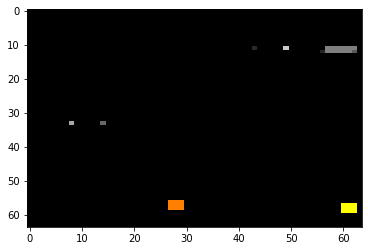

In [17]:

obs = env.reset()
a = 0
for i in range(1000):
    if (i + 1) % 40 == 0:
        a = env.action_space.sample()
    observation, reward, done, info = env.step(a)
    #print(observation.shape)
    #print(observation)
    if (i + 1) % 5 == 0:
        clear_output(True)
        #print(observation.shape)
        #plt.imshow(observation.astype(np.int32))
        plt.imshow(observation, interpolation='none', aspect='auto')
        plt.show()
    if done:
        break

Store frames in frame buffer:

-- PROBLEM: the image seems flashy!


In [18]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper

# TODO: Maybe consequtive frames are not the best because they don't capture movement as much

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=16, frame_batch_size=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        
        assert n_frames % frame_batch_size == 0, "number of frames shoud be dividable by frame_batch_size"
        
        super(FrameBuffer, self).__init__(env)
        height, width, n_channels= env.observation_space.shape
        obs_shape = (height, width, n_channels * n_frames // frame_batch_size)
        frame_buffer_shape = (height, width, n_channels * n_frames)
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(frame_buffer_shape, 'float32')
        self.compressed_buffer = np.zeros(obs_shape, 'float32')
        self.frame_batch_size = frame_batch_size
        self.cyclic = frame_batch_size
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.compressed_buffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.compressed_buffer, reward, done, info

    def update_buffer(self, img):
        offset = self.env.observation_space.shape[2]
        axis = 2
        cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)
        
        self.cyclic -= 1
        if self.cyclic == 0:
            self.cyclic = self.frame_batch_size
            self.compressed_buffer = self.compressed_buffer[:,:,:-offset]
            batch_section = self.framebuffer[:,:,:offset*self.cyclic]
            picker = offset * np.arange(self.cyclic)
            for i in range(offset):
                #print((offset - i - 1) + picker)
                avg = np.expand_dims(np.mean(batch_section[:,:,(offset - i - 1) + picker], axis=2), 2)
            
                self.compressed_buffer = np.concatenate(
                    [avg, self.compressed_buffer], axis=axis)

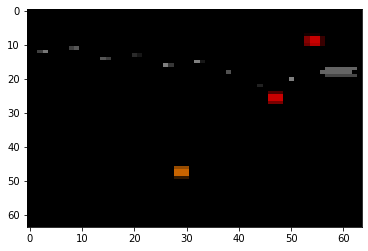

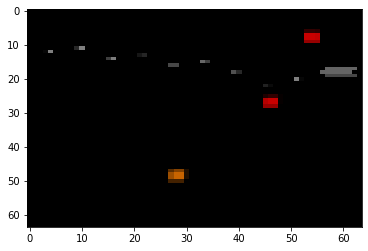

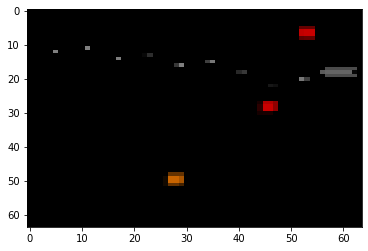

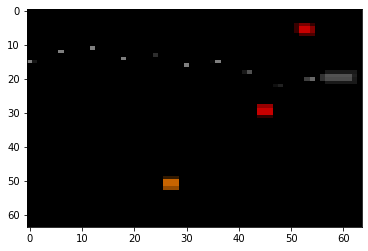

3
(64, 64, 12)


In [19]:
from IPython.display import clear_output

env = gym.make(ENV_NAME)
env = PreprocessAtariObs(env)
env = FrameBuffer(env)
n_actions = env.action_space.n
state_shape = env.observation_space.shape
print(state_shape)
s = env.reset()
# s, _, _, _ = env.step(env.action_space.sample())
# s, _, _, _ = env.step(env.action_space.sample())
# print("HO1")
# s, _, _, _ = env.step(env.action_space.sample())
# print("HO2")
# s, _, _, _ = env.step(env.action_space.sample())
a = 0
for i in range(1000):
    if (i + 1) % 5 == 0:
        a = env.action_space.sample()
    s, _, done, _ = env.step(a)
    if done:
        break
    if (i + 1) % 20 == 0:
        clear_output(True)
        for f in range(4):
            plt.imshow(s[:,:,f * 3:f * 3 + 3], interpolation='none', aspect='auto')
            plt.show()
print(n_actions)
print(state_shape)

### The DQN architecture

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

(HERE SHOULD BE A PHOTO)

In [20]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cpu')

In [21]:
class DQNAgent(nn.Module):
    def __init__(self, env, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.state_shape = (env.observation_space.shape[2],
                            env.observation_space.shape[0],
                            env.observation_space.shape[1])
        self.n_actions = env.action_space.n
        self.conv1 = nn.Conv2d(self.state_shape[0], 16, (3, 3), 2)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), 2)
        self.conv3 = nn.Conv2d(32, 64, (3, 3), 2)
        self.linear = self.linear1 = nn.Linear(3136, self.n_actions)
        
        # TODO: one RELU for all?!
        self.ReLU = nn.ReLU()
        self.Flatten = nn.Flatten()
        
        # Define your network body here. Please make sure agent is fully contained here
        # nn.Flatten() can be useful
        #<YOUR CODE>
        #self.layers = nn.Sequential(
            
        #)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, h, w, 4 * c]
        """
        # Use your network to compute qvalues for given state
        state_t = state_t.transpose(3, 2)
        state_t = state_t.transpose(2, 1)
        state_t = self.ReLU(self.conv1(state_t))
        state_t = self.ReLU(self.conv2(state_t))
        state_t = self.ReLU(self.conv3(state_t))
        qvalues = self.ReLU(self.linear(self.Flatten(state_t)))
        

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == self.n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [22]:
env = gym.make(ENV_NAME)
env = PreprocessAtariObs(env)
env = FrameBuffer(env)
print('Observation space shape: {}\nAction space count: {}'.format(env.observation_space.shape, env.action_space.n))
agent = DQNAgent(env, epsilon=0.5).to(device)

Observation space shape: (64, 64, 12)
Action space count: 3


Run the agent to see if it encounters any errors:

In [63]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, visualize=False):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in trange(n_games):
        s = env.reset()
        reward = 0
        for t in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            if visualize and (t + 1) % 20 == 0:
                clear_output(True)
                plt.imshow(s[:,:,0:3], interpolation='none', aspect='auto')
                plt.show()   
                #print(reward)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

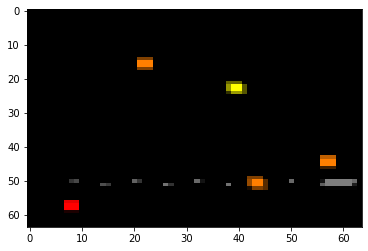

-771.0

In [24]:
evaluate(env, agent, n_games=15, visualize=True)

### Experience Replay

The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for batch_size random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [25]:
# This code is shamelessly stolen from
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
import numpy as np
import random


class ReplayBuffer:
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        # fill the data cyclically, if the list is not yet complete append it
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

Check whether the Replay Buffer works:

In [26]:

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [27]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for i in range(n_steps):
        q_values = agent.get_qvalues([s])
        a = agent.sample_actions(q_values)[0]
        s_, rwd, done, info = env.step(a)
        sum_rewards += rwd
        exp_replay.add(s, a, rwd, s_, done)
        if done:
            s = env.reset()
        else:
            s = s_
            
    return sum_rewards, s

In [36]:
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


How to use target networks

In [28]:
target_network = DQNAgent(env, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Q-Learning

In [32]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = predicted_next_qvalues.max(-1)[0]

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + is_not_done * gamma * next_state_values

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks!

In [31]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

AssertionError: loss must be differentiable w.r.t. network weights

## Main Learning Loop

In [45]:
from tqdm import trange, tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [34]:
seed = 2022#<YOUR CODE: your favourite random seed>
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [38]:
env = gym.make(ENV_NAME)
env.seed(seed)
env = PreprocessAtariObs(env)
env = FrameBuffer(env)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
print(state_shape)
print(n_actions)
state = env.reset()
agent = DQNAgent(env, epsilon=1).to(device)
target_network = DQNAgent(env).to(device)
target_network.load_state_dict(agent.state_dict())

(64, 64, 12)
3


<All keys matched successfully>

Buffer of size  104  fits into 5 Gb RAM.

Larger sizes ( 105  and  106  are common) can be used. It can improve the learning, but  104  is quiet enough.  102  will probably fail learning.

In [42]:
import psutil

def is_enough_ram(min_available_gb=0.1):
    mem = psutil.virtual_memory()
    return mem.available >= min_available_gb * (1024 ** 3)

In [46]:
exp_replay = ReplayBuffer(10**4)
for i in tqdm(range(100)):
    if not is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

 99%|█████████████████████████████████████████▌| 99/100 [02:49<00:01,  1.72s/it]

10000


In [47]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [56]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [67]:
from scipy.signal import convolve, gaussian

def linear_decay(init_val, final_val, cur_step, total_steps):
    if cur_step >= total_steps:
        return final_val
    return (init_val * (total_steps - cur_step) +
            final_val * cur_step) / total_steps

def smoothen(values):
    kernel = gaussian(100, std=100)
    # kernel = np.concatenate([np.arange(100), np.arange(99, -1, -1)])
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

In [69]:
state = env.reset()
for step in trange(step, total_steps + 1):
    if not is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everythin is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    #print("epsilon = {}".format(agent.epsilon))
    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)
    #print("Played!")
    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)
    #print("Calculated Loss")
    #<YOUR CODE: sample batch_size of data from experience replay>

    #loss = <YOUR CODE: compute TD loss>

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()
    
    #print("Backprop done!")
    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        #target_network = DQNAgent(env).to(device)
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        env = gym.make(ENV_NAME)
        env.seed(seed)
        env = PreprocessAtariObs(env)
        env = FrameBuffer(env)
        print("Started evaluating")
        print("start rw history")
        n_lives = 1
        mean_rw_history.append(evaluate(
            env, agent, n_games=3 * n_lives, greedy=True)
        )
        
        env = gym.make(ENV_NAME)
        env.seed(seed)
        env = PreprocessAtariObs(env)
        env = FrameBuffer(env)
        print("Start init 'q' values")
        initial_state_q_values = agent.get_qvalues(
            [env.reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(smoothen(grad_norm_history))
        plt.grid()

        plt.show()

  0%|                                 | 2286/2999861 [01:05<23:49:45, 34.94it/s]


KeyboardInterrupt: 